# CLUSTER GROCERY ITEMS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
table1 = pd.read_csv('grocery/item_to_id.csv')
table2 = pd.read_csv('grocery/purchase_history.csv')

In [3]:
table1.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [5]:
table2new = pd.DataFrame(columns=['user_id', 'item_id'])

for i, row in table2.iterrows():
    row_items = row['id'].strip().split(',')
    for row_item in row_items:
        table2new = table2new.append({'user_id':row['user_id'], 'item_id':int(row_item)}, ignore_index=True)   

table2new.head()

,user_id,item_id
0,222087,27
1,222087,26
2,1343649,6
3,1343649,47
4,1343649,17


In [6]:
table2new.to_csv('grocery/purchase_history_sep.csv', index=False)

In [53]:
table3 = pd.read_csv('grocery/purchase_history_sep.csv')

In [8]:
table3.head()

,user_id,item_id
0,222087,27
1,222087,26
2,1343649,6
3,1343649,47
4,1343649,17


In [ ]:
#import MySQLdb
#Enter the values for you database connection
#dsn_database = "Enter Database name"   # e.g. "MySQLdbtest"
#dsn_hostname = "<Enter Hostname"       # e.g.: "mydbinstance.xyz.us-east-1.rds.amazonaws.com"
#dsn_port = 3306                        # e.g. 3306 
#dsn_uid = "<Enter UserID>"             # e.g. "user1"
#dsn_pwd = "<Enter Password"            # e.g. "Password123"
#conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)

### CUSTOMERS WHO BOUGHT THE MOST ITEMS OVERALL IN HER LIFETIME

### CUSTOMERS WHO BOUGHT EACH PRODUCT THE MOST

In [ ]:
## SQL SOLUTION
-- customer who bought the most items in her lifetime 

SELECT user_id, COUNT(*) AS items_bought
FROM takehome_challenges.purchase_history_sep
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 1;

-- customers who bought each product the most
SELECT item_name, user_id, vol_per_item
FROM 
    (
    SELECT i.item_name, p.user_id, RANK() OVER (PARTITION BY p.item_id ORDER BY p.vol_per_item DESC) AS rk, p.vol_per_item 
    FROM (
        SELECT user_id, item_id, COUNT(*) AS vol_per_item
        FROM takehome_challenges.purchase_history_sep
        GROUP BY 1, 2
        ) p
    LEFT JOIN takehome_challenges.item_to_id i 
    ON p.item_id = i.item_id 
    ORDER BY 1, 3 ASC
    ) temp 
WHERE rk = 1
ORDER BY 1, 2; 



-- simplified subqueries
SELECT i.Item_name, temp.user_id, temp.items_per_user 
FROM
(
SELECT user_id, item_id, COUNT(*) AS items_per_user,
    RANK() OVER (PARTITION BY item_id ORDER BY COUNT(*) DESC) AS rnk
FROM takehome_challenges.purchase_history_sep
GROUP BY 1, 2
) temp 
RIGHT JOIN takehome_challenges.item_to_id i
ON i.Item_id = temp.item_id
WHERE rnk = 1
ORDER BY 1;

In [55]:
table3.sort_values('user_id').head()

,user_id,item_id
260539,47,45
260530,47,3
260531,47,4
260532,47,2
260533,47,13


In [ ]:
table3_merge = pd.merge(table3, table1, left_on='item_id', right_on='Item_id', 
                        how='right')[['user_id', 'Item_name']].sort_values('user_id')

### CLUSTER ITEMS. EACH ITEM IS AN OBSERVATION, EACH USER IS A FEATURE, USER ORDER IS THE VALUE OF THE FEATURE.

In [76]:
table3_merge['order'] = 1
table3_pivot = table3_merge.groupby(['user_id', 'Item_name']).count().reset_index().pivot_table(
    columns='user_id', index='Item_name', values='order', fill_value=0)
table3_pivot.columns.name = None
table3_pivot.index.name = None
table3_pivot.head()

,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
aluminum foil,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
apples,0,0,1,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
baby items,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
bagels,1,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,1
bananas,1,0,1,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0


### USE PCA TO PLOT THE ITEMS 

array([0.09277058, 0.04382437])

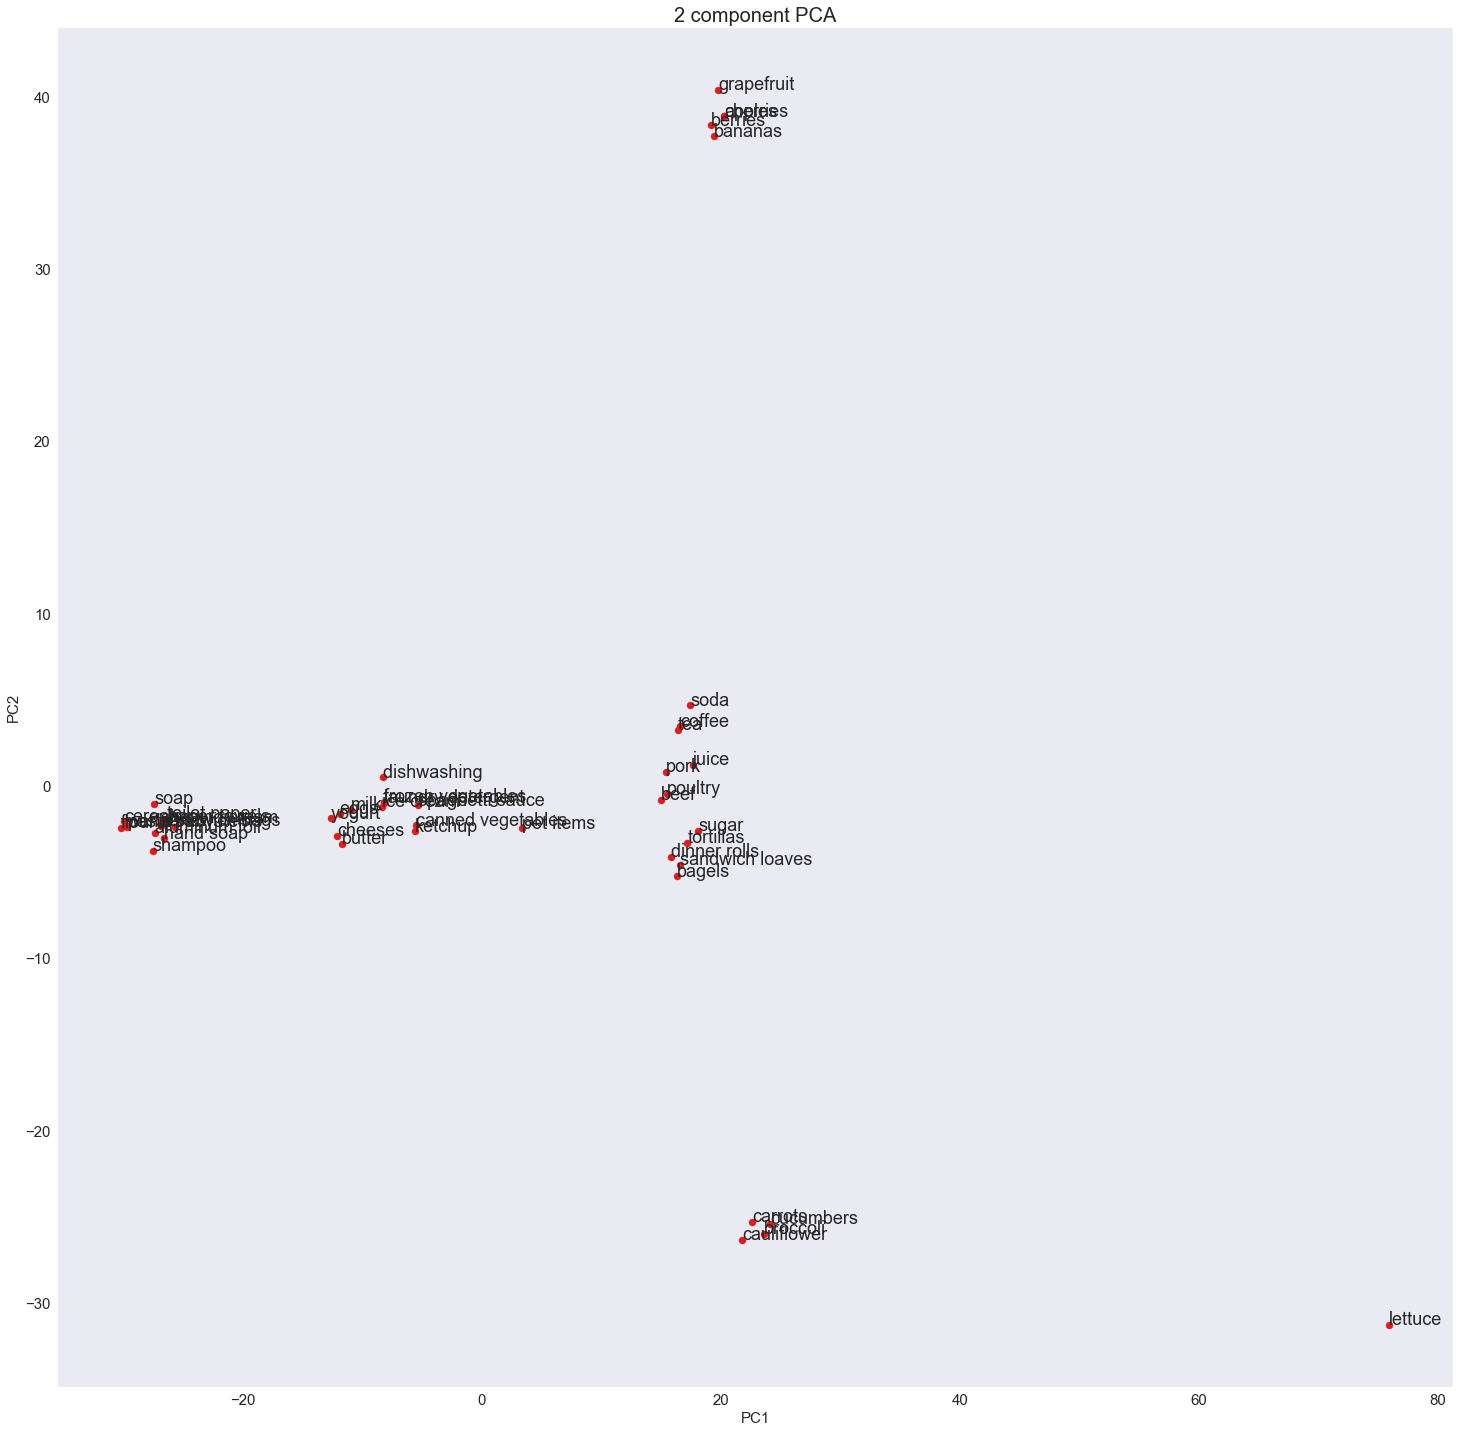

In [90]:
import seaborn as sns
sns.set(font_scale=1.5, palette='Set1')
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

PCs = pca.fit_transform(table3_pivot)

PCdf = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
PCdf.index = table3_pivot.index


fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)


ax.scatter(PCdf['PC1'], PCdf['PC2'], s=50)

ax.grid()

for item in PCdf.index:
    x = PCdf.loc[item,'PC1']
    y = PCdf.loc[item,'PC2']
    plt.text(x,y,item)

pca.explained_variance_ratio_

In [91]:
from sklearn.cluster import KMeans

KM = KMeans(n_clusters=6, random_state=0)
KM.fit_predict(table3_pivot)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 1, 2,
       0, 0, 0, 0])